<a href="https://colab.research.google.com/github/nova-zl504/wasserstein-GP-minist/blob/master/wan_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = (images + 1.0) / 2.0 * 255
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    plt.show()
    return

# Dataset

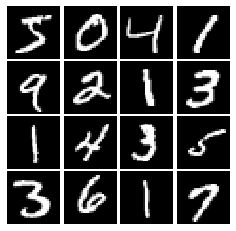

In [2]:
class MNIST(object):
    def __init__(self, batch_size, shuffle=False):
        """
        Construct an iterator object over the MNIST data
        
        Inputs:
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        train, _ = tf.keras.datasets.mnist.load_data()
        X, y = train
        X = (X.astype(np.float32)/255 * 2.0) - 1.0
        X = X.reshape((X.shape[0], 28, 28, 1))
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B)) 

# show a batch
mnist = MNIST(batch_size=16, shuffle=True)
show_images(mnist.X[:16])

# Leaky Relu

In [0]:
def leaky_relu(X, alpha=1e-2):
  return tf.maximum(X * alpha, X)

# Pixel Normalization

In [0]:
def pixel_norm(x, epsilon=1e-8):
    with tf.variable_scope('PixelNorm'):
        return x * tf.rsqrt(tf.reduce_mean(tf.square(x), axis=1, keepdims=True) + epsilon)

# Discriminator

In [0]:
def discriminator(images):
  
  with tf.variable_scope('discriminator'):
    net = tf.identity(images, name='input')
    
    net = tf.layers.conv2d(net, filters=32, kernel_size=5, strides=1,
                          padding='VALID', name='conv.1')
    net = pixel_norm(net)
    net = leaky_relu(net)
    
    net = tf.layers.max_pooling2d(net, 2, 2)
    
    net = tf.layers.conv2d(net, filters=64, kernel_size=5, strides=1,
                          padding='VALID', name='conv.2')
    net = pixel_norm(net)
    net = leaky_relu(net)
    
    net = tf.layers.max_pooling2d(net, 2, 2)
    
    net = tf.layers.flatten(net)
    net = tf.layers.dense(net, 4 * 4 * 64, name='dense.3')
    net = pixel_norm(net)
    net = leaky_relu(net)
    
    net = tf.layers.dense(net, 1, name='dense.4')
    #net = tf.nn.softmax(net)
    
    return tf.identity(net, name='output')

# Generator

In [0]:
def generator(Z):
  with tf.variable_scope('generator'):
    net = tf.identity(Z, name='input')
    
    net = tf.layers.dense(net, 7*7*8)
    net = pixel_norm(net)
    net = tf.nn.relu(net)
    
    net = tf.reshape(net, shape=(tf.shape(Z)[0], 7, 7, 8))
        
    net = tf.layers.conv2d_transpose(net, filters=64, kernel_size=1,
                                    strides=1, padding='SAME')
    net = pixel_norm(net)
    net = tf.nn.relu(net)
    
    for i in range(2):
      residual = net
      net = tf.layers.conv2d(net, filters=64*6, kernel_size=1,
                                    strides=1, padding='VALID')
      net = pixel_norm(net)
      net = tf.nn.relu(net)
      
      net = tf.layers.separable_conv2d(net, filters=64*6, kernel_size=3,
                                      strides=1, padding='SAME')
      net = pixel_norm(net)
      net = tf.nn.relu(net)
      
      net = tf.layers.conv2d(net, filters=64, kernel_size=1,
                                    strides=1, padding='VALID')

      net = net + residual
    
    net = tf.layers.conv2d_transpose(net, filters=32, kernel_size=4,
                                    strides=2, padding='SAME')
    net = pixel_norm(net)
    net = tf.nn.relu(net)
    
    net = tf.layers.conv2d_transpose(net, filters=1, kernel_size=4,
                                    strides=2, padding='SAME',
                                    activation='tanh')
    
    return tf.identity(net, name='output')

In [0]:
def losses(fake_images, real_images, fake_logits, real_logits, alpha):
  differences = fake_images - real_images
  interpolates = real_images + (alpha * differences)
  gradients = tf.gradients(discriminator(interpolates), [interpolates])[0]
  slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]) + 1e-10)
  gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.))
  G_loss = -tf.reduce_mean(fake_logits)  
  D_loss = tf.reduce_mean(fake_logits) \
    - tf.reduce_mean(real_logits) \
    + 10.0 * gradient_penalty
  return G_loss, D_loss


# Build the Whole Graph

In [11]:
epoch_count = 100
batch_size = 256

learning_rate=1e-3
beta1=0.5

CHECKPOINTS_DIR='checkpoints'

tf.reset_default_graph()

real_images = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28, 1)
                             , name='real_images')
alpha = tf.placeholder(dtype=tf.float32, shape=(None, 1, 1, 1))
# noise will be fed into generator
noise = tf.random_uniform((batch_size, 128), minval=-1, maxval=1)
# fake images 
fake_images = generator(noise)

print(fake_images.shape)

with tf.variable_scope('') as scope:
  real_logits = discriminator(real_images)
  scope.reuse_variables()
  fake_logits = discriminator(fake_images)
  G_loss, D_loss = losses(fake_images, real_images, fake_logits, real_logits, alpha)
  #G_loss, D_loss = loss_simple_gp(fake_images, real_images, fake_logits, real_logits, alpha)



D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
  
#G_loss, D_loss = least_loss(fake_logits, real_logits)

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')


D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

(256, 28, 28, 1)


#Train

epoch 1


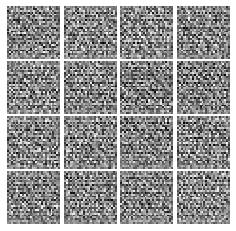

iteration: 234 - D_loss: -37.88392639160156 - G_loss: 47.492759704589844
epoch 2


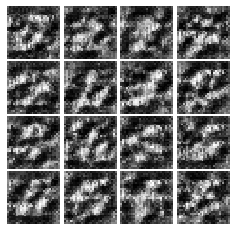

iteration: 234 - D_loss: -21.072933197021484 - G_loss: 28.855491638183594
epoch 3


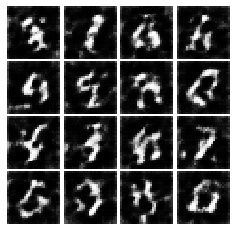

iteration: 234 - D_loss: -16.01509666442871 - G_loss: 20.977149963378906
epoch 4


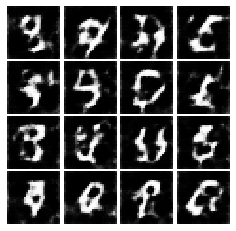

iteration: 234 - D_loss: -13.433862686157227 - G_loss: 54.229225158691406
epoch 5


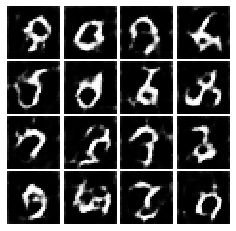

iteration: 234 - D_loss: -17.823501586914062 - G_loss: 73.85932922363281
epoch 6


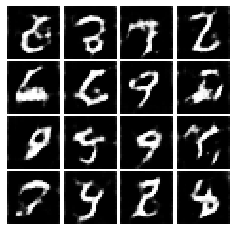

iteration: 234 - D_loss: -20.864025115966797 - G_loss: 50.741661071777344
epoch 7


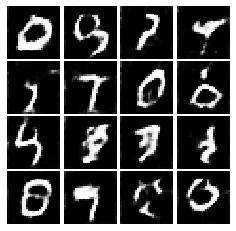

iteration: 234 - D_loss: -16.895166397094727 - G_loss: 79.0981674194336
epoch 8


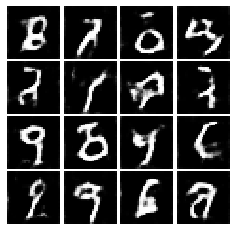

iteration: 234 - D_loss: -17.883453369140625 - G_loss: 84.23151397705078
epoch 9


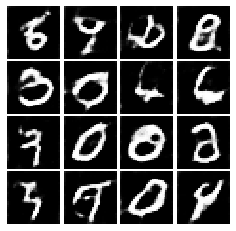

iteration: 144 - D_loss: 5.634049415588379 - G_loss: 77.29766845703125

In [0]:
def show_samples(sess):
  samples = sess.run(fake_images)
  show_images(samples[:16])
  
def sample_noise(batch_size):
  return np.random.uniform(size=(batch_size, 1, 1, 1))

def on_epoch(sess):
  mnist = MNIST(batch_size=batch_size, shuffle=True)
  iter_counter = 1
  for (X, _) in mnist:
    if X.shape[0] != 256:
      continue
      
    D_loss_value, G_loss_value = None, None
    if iter_counter == 0 or iter_counter % 6 != 0:
      _, _D_loss = sess.run([D_train_step, D_loss], \
                            feed_dict={real_images: X, \
                                       alpha: sample_noise(X.shape[0])})

    else:    
      _, _G_loss = sess.run([G_train_step, G_loss], \
                            feed_dict={real_images: X, \
                                       alpha: sample_noise(X.shape[0])})
      
      print('\riteration: {} - D_loss: {} - G_loss: {}' \
            .format(iter_counter, _D_loss, _G_loss), end='')

    iter_counter += 1

  print('')
  return iter_counter


if not os.path.exists(CHECKPOINTS_DIR):
  os.makedirs(CHECKPOINTS_DIR)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  saver = tf.train.Saver(var_list=D_vars + G_vars,
                         save_relative_paths=True)
  
  for epoch in range(epoch_count):
    print('epoch {}'.format(epoch + 1)) 

    # Calculate Samples
    show_samples(sess)
    
    # epoch iterations
    iterations = on_epoch(sess)

    # save checkpoints
    saver.save(sess, '{}/dcgan'.format(CHECKPOINTS_DIR),
           global_step=(epoch+1) * iterations)

  
  
  print("Final Image:")
  # Calculate Samples
  show_samples(sess)


